In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import pickle
import math

#Scikit-Learn Importing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from scipy.stats.mstats import gmean, kurtosis, skew

#Import PyWavelets for WaveSmoothing
import pywt
import mad
from statsmodels import robust

#Import Keras
import keras
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from tqdm import tqdm
from keras import backend as K

#Import Gridsearch
from hypopt import GridSearch

#Import Capstone Functions
from Capstone_Functions import *
cf = CapstoneFunctions()

#Import PyFolio
#import pyfolio as pf

#Import Seaborn
import seaborn as sns

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
Monthly = pd.read_pickle('data/Monthly.pkl')
Daily = pd.read_pickle('data/Daily.pkl')
Monthly2 = pd.read_pickle('data/MonthlyReturns.pkl')

In [3]:
WOMonthly = Monthly.iloc[:,14:15].copy()
WOMonthly.head()

,WOMonthly
date,
1990-12-03,0.052244
1991-01-01,0.011277
1991-02-01,0.015239
1991-03-01,0.096461
1991-04-01,0.026566


In [4]:
FIPMonthly = Monthly2.iloc[:,16:17].copy()
FIPMonthly.head()

,FIPMonthly
date,
1990-12-03,0.034620
1991-01-01,0.022021
1991-02-01,0.013218
1991-03-01,0.089188
1991-04-01,0.031861


In [5]:
SandP = pd.read_excel('S&P.xlsx', index_col="date")
SandP = SandP.copy()
SandP_Monthly = SandP.resample('BMS').first()
SandPreturns = SandP_Monthly.pct_change().dropna()
SandPreturnsMonthly = SandPreturns.loc['1990-12-03':]
SandPreturnsMonthly.head()

,sandp
date,
1990-12-03,0.055632
1991-01-01,0.018883
1991-02-01,0.038853
1991-03-01,0.079930
1991-04-01,0.002240


In [6]:
SandPreturnsMonthly.shape

(356, 1)

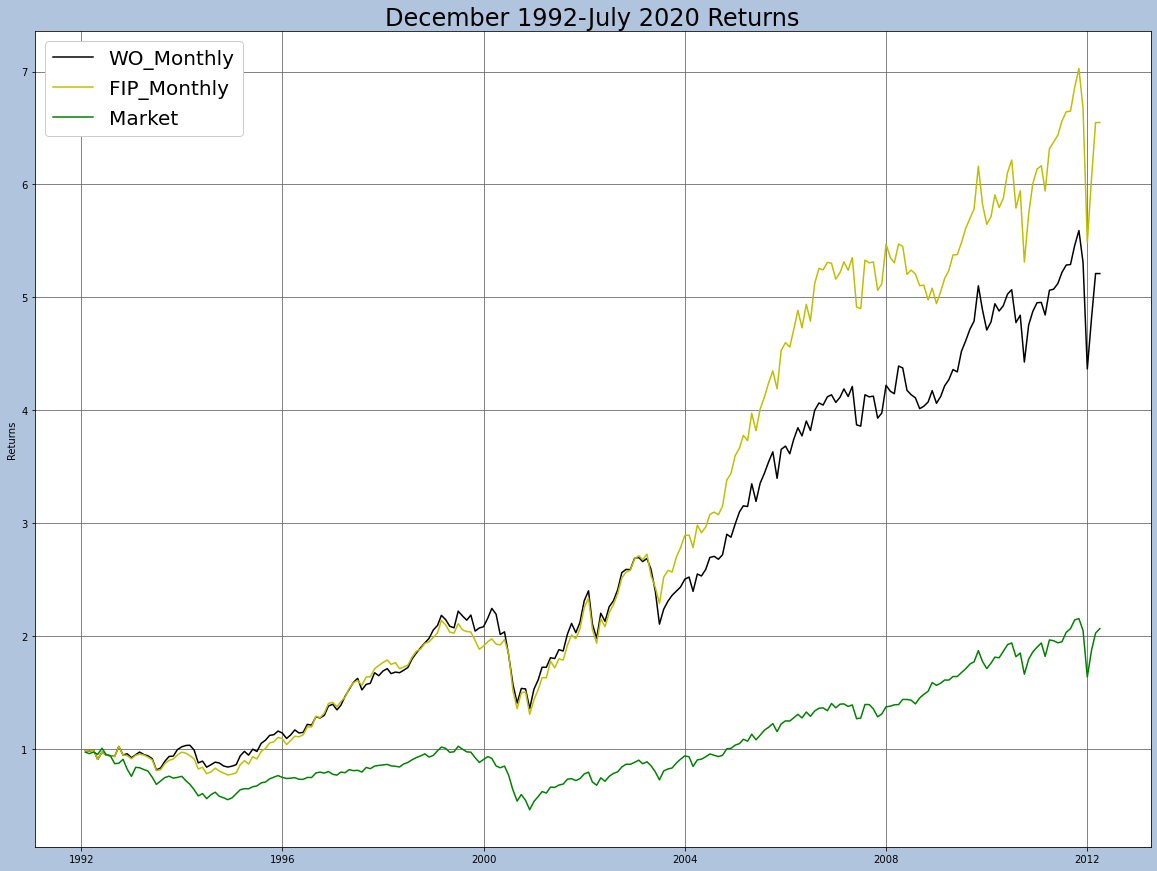

In [7]:
WOMonthly_test = WOMonthly.loc['1992-01-01':].copy()
FIPMonthly_test = FIPMonthly.loc['1992-01-01':].copy()
SandPreturnsMonthly_test = SandPreturnsMonthly.loc['1992-01-01':].copy()


month = 100

WOMonthly_test['WOMtmp']=WOMonthly_test['WOMonthly']+1
WOMonthly_test['WOMcum']=np.cumprod(WOMonthly_test['WOMtmp'].iloc[month:])

FIPMonthly_test['FIPtmp']=FIPMonthly_test['FIPMonthly']+1
FIPMonthly_test['FIPcum']=np.cumprod(FIPMonthly_test['FIPtmp'].iloc[month:])

SandPreturnsMonthly_test['Mkttmp']=SandPreturnsMonthly_test['sandp']+1
SandPreturnsMonthly_test['Mktcum']=np.cumprod(SandPreturnsMonthly_test['Mkttmp'].iloc[month:])

idx = pd.date_range('1992-01-01', periods=243, freq='M') # '2008-01-01', periods=135

plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("white")
plt.rcParams.update({'font.size': 20})
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.plot(idx, (WOMonthly_test['WOMcum'].iloc[month:]), 'k', label='WO_Monthly')
plt.plot(idx, (FIPMonthly_test['FIPcum'].iloc[month:]), 'y', label='FIP_Monthly')
plt.plot(idx, (SandPreturnsMonthly_test['Mktcum'].iloc[month:]), 'g', label='Market')
plt.title("December 1992-July 2020 Returns")                           
plt.ylabel('Returns')
plt.legend(facecolor='white', framealpha=1)
#plt.axhline(y=1)
plt.show()
#plt.savefig('regular-cumret-sub.png', bbox_inches='tight')

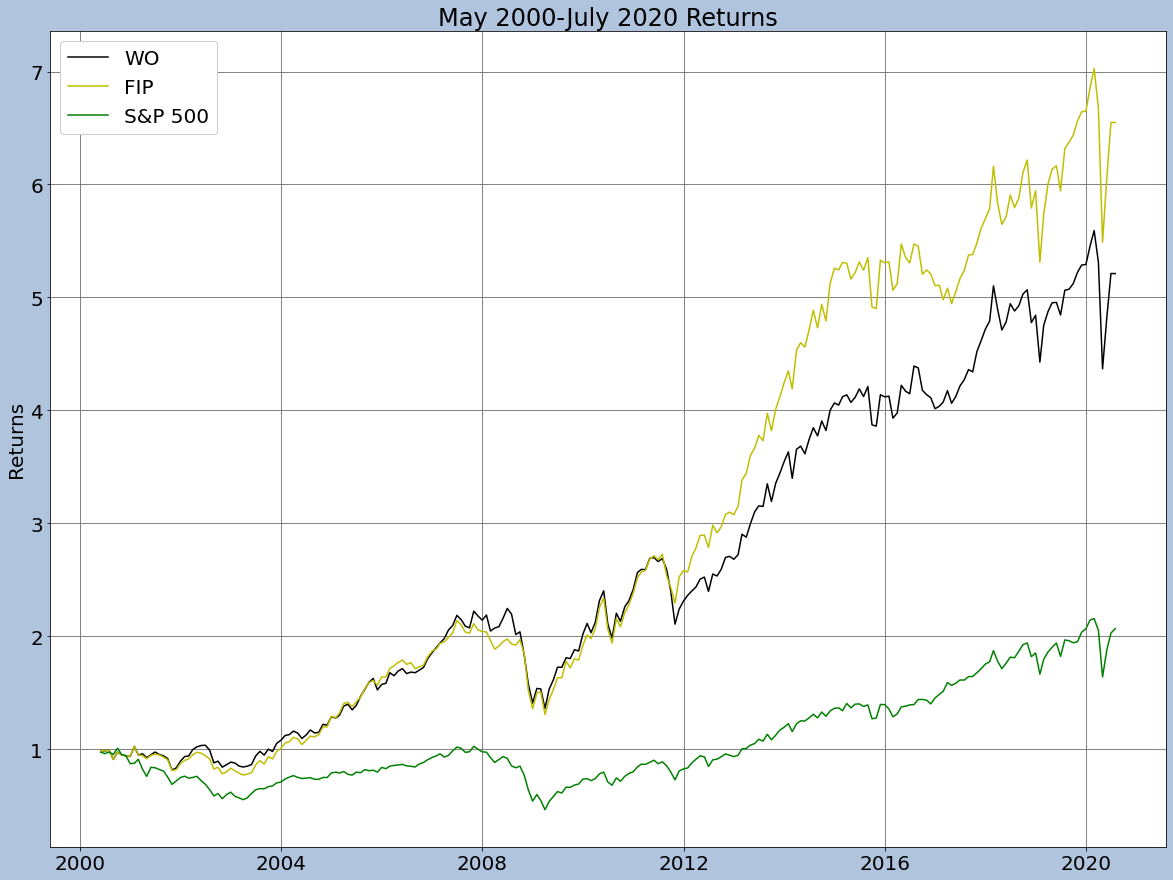

In [8]:
WOMonthly_test = WOMonthly.loc['2000-05-01':].copy()
FIPMonthly_test = FIPMonthly.loc['2000-05-01':].copy()
SandPreturnsMonthly_test = SandPreturnsMonthly.loc['2000-05-01':].copy()


month = 0

WOMonthly_test['WOMtmp']=WOMonthly_test['WOMonthly']+1
WOMonthly_test['WOMcum']=np.cumprod(WOMonthly_test['WOMtmp'].iloc[month:])

FIPMonthly_test['FIPtmp']=FIPMonthly_test['FIPMonthly']+1
FIPMonthly_test['FIPcum']=np.cumprod(FIPMonthly_test['FIPtmp'].iloc[month:])

SandPreturnsMonthly_test['Mkttmp']=SandPreturnsMonthly_test['sandp']+1
SandPreturnsMonthly_test['Mktcum']=np.cumprod(SandPreturnsMonthly_test['Mkttmp'].iloc[month:])

idx = pd.date_range('2000-05-01', periods=243, freq='M') # '2008-01-01', periods=135

plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("white")
plt.rcParams.update({'font.size': 20})
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.plot(idx, (WOMonthly_test['WOMcum'].iloc[month:]), 'k', label='WO')
plt.plot(idx, (FIPMonthly_test['FIPcum'].iloc[month:]), 'y', label='FIP')
plt.plot(idx, (SandPreturnsMonthly_test['Mktcum'].iloc[month:]), 'g', label='S&P 500')
plt.title("May 2000-July 2020 Returns")                           
plt.ylabel('Returns')
plt.legend(facecolor='white', framealpha=1)
#plt.axhline(y=1)
plt.show()
#plt.savefig('regular-cumret-sub.png', bbox_inches='tight')

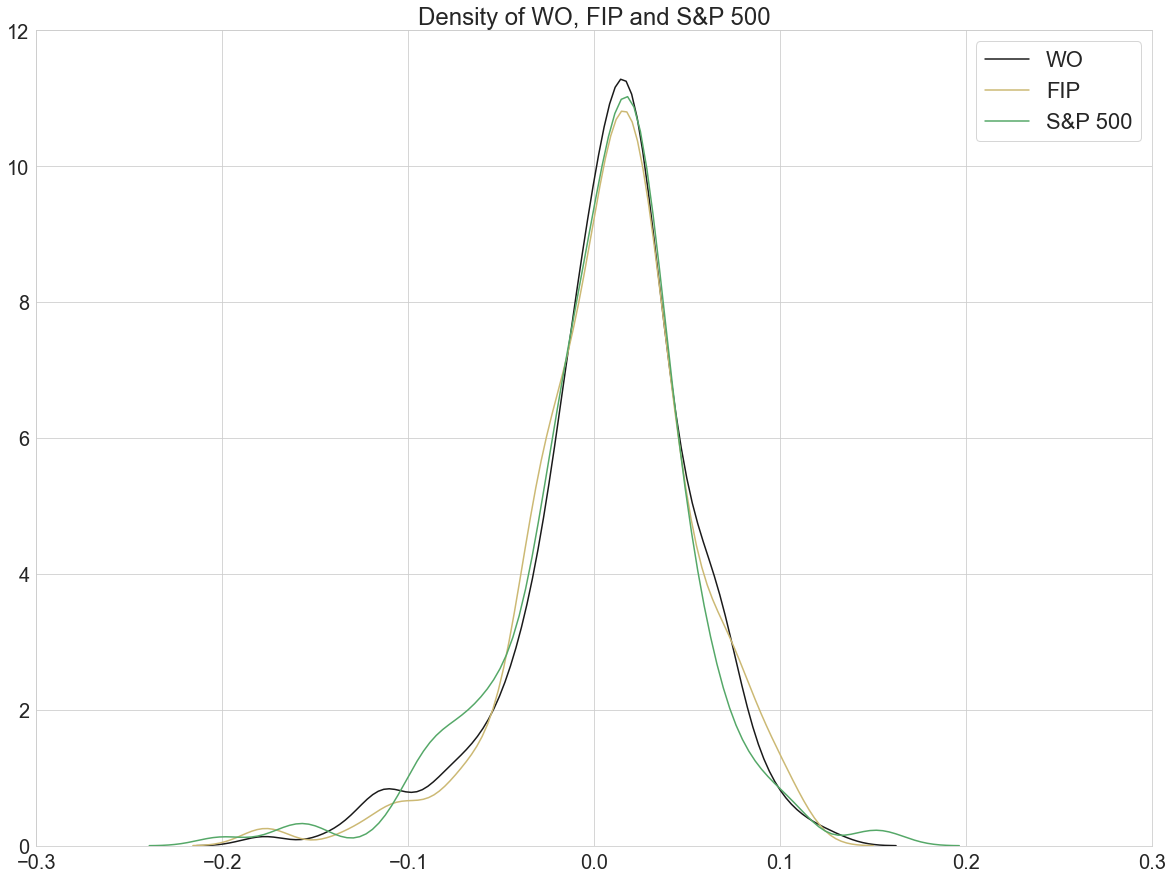

In [9]:
fig = plt.gcf()
sns.set_style("whitegrid")
fig.set_size_inches(20, 15)
p1=sns.kdeplot(WOMonthly_test['WOMonthly'], shade=False, color="k", label='WO').set_title('Density of WO, FIP and S&P 500')
p1=sns.kdeplot(FIPMonthly_test['FIPMonthly'], shade=False, color="y", label='FIP')
p1=sns.kdeplot(SandPreturnsMonthly_test['sandp'], shade=False, color="g", label='S&P 500')
plt.xlim(-0.3, 0.3)
plt.ylim(0, 12)
sns.set(font_scale=2)
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

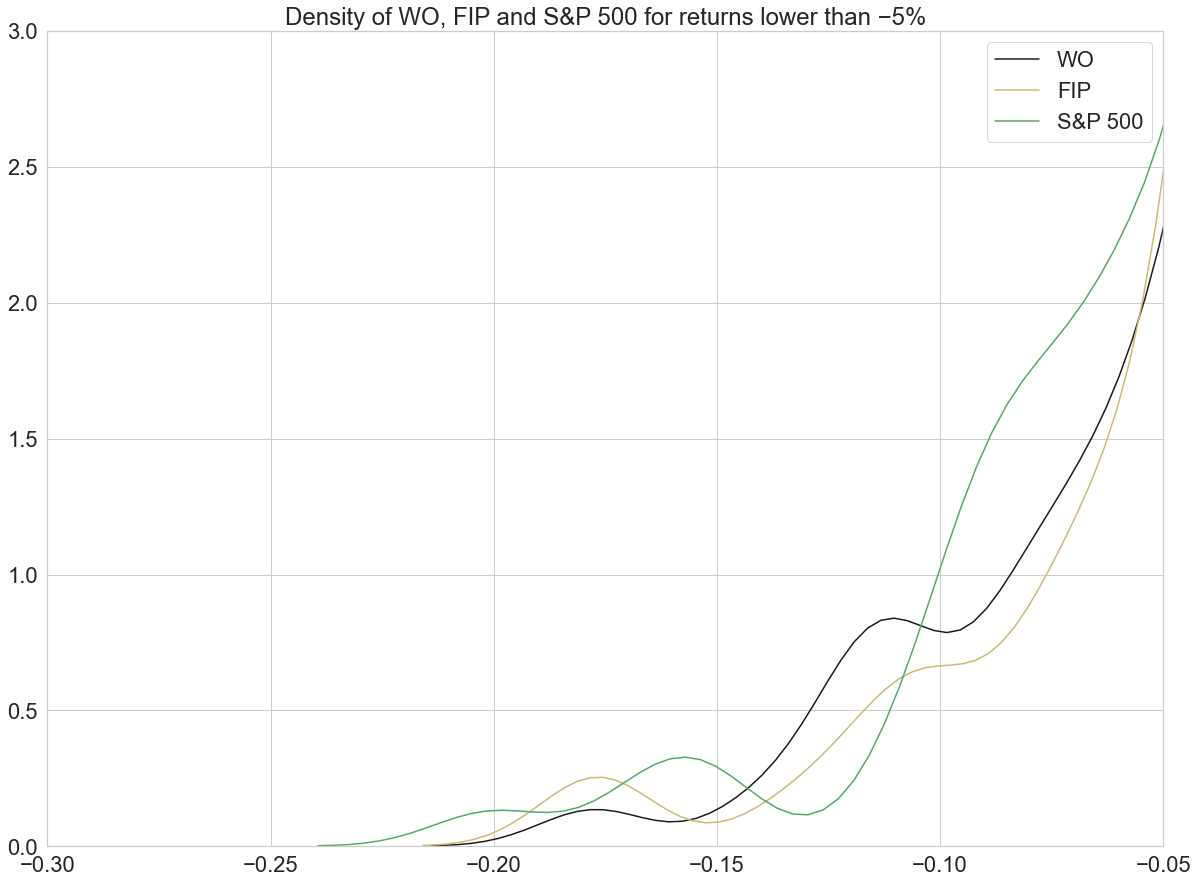

In [10]:
fig = plt.gcf()
sns.set_style("whitegrid")
fig.set_size_inches(20, 15)
p1=sns.kdeplot(WOMonthly_test['WOMonthly'], shade=False, color="k", label='WO').set_title('Density of WO, FIP and S&P 500 for returns lower than −5%')
p1=sns.kdeplot(FIPMonthly_test['FIPMonthly'], shade=False, color="y", label='FIP')
p1=sns.kdeplot(SandPreturnsMonthly_test['sandp'], shade=False, color="g", label='S&P 500')
plt.xlim(-0.3, -0.05)
plt.ylim(0, 3)
sns.set(font_scale=2)
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

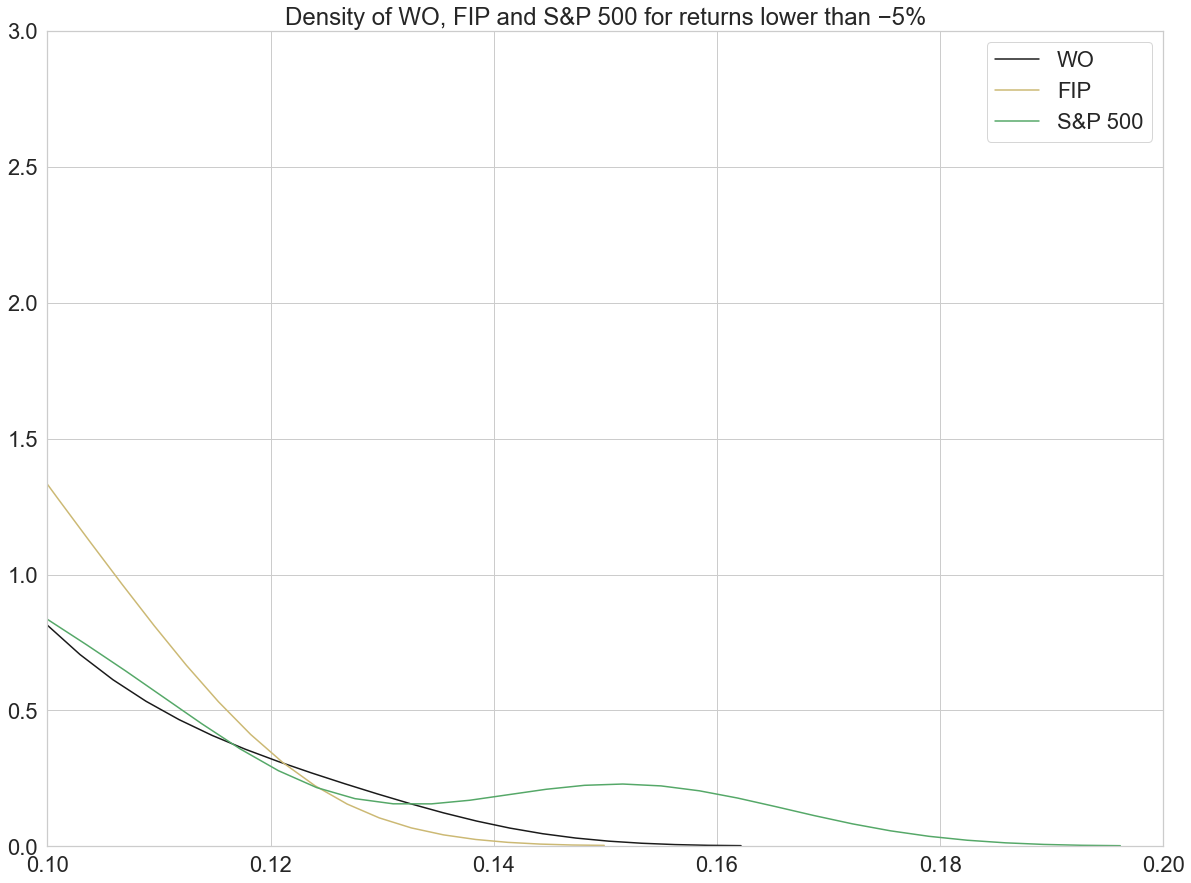

In [11]:
fig = plt.gcf()
fig.set_size_inches(20, 15)
sns.set_style("whitegrid")
p1=sns.kdeplot(WOMonthly_test['WOMonthly'], shade=False, color="k", label='WO').set_title('Density of WO, FIP and S&P 500 for returns lower than −5%')
p1=sns.kdeplot(FIPMonthly_test['FIPMonthly'], shade=False, color="y", label='FIP')
p1=sns.kdeplot(SandPreturnsMonthly_test['sandp'], shade=False, color="g", label='S&P 500')
plt.xlim(0.1, 0.2)
plt.ylim(0, 3)
sns.set(font_scale=2)
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

In [12]:
DailyData = Daily.loc[:,'WODaily':'WODaily'].copy()
MonthlyData = Monthly.loc['1991-06-03':,'WOMonthly':'WOMonthly'].copy()

def summing(X):
    X = X.sum()
    return X

DailyData = DailyData.rolling(21).sum()**2
DailyData2 = DailyData.resample('BMS').first()
DailyData2 = ((DailyData2.rolling(6).apply(summing))*(21/126))**(1/2)
DailyData2 = (0.05/DailyData2)
DailyData2 = DailyData2.dropna()
MonthlyData['Scaled'] = MonthlyData['WOMonthly'].multiply(DailyData2['WODaily'])

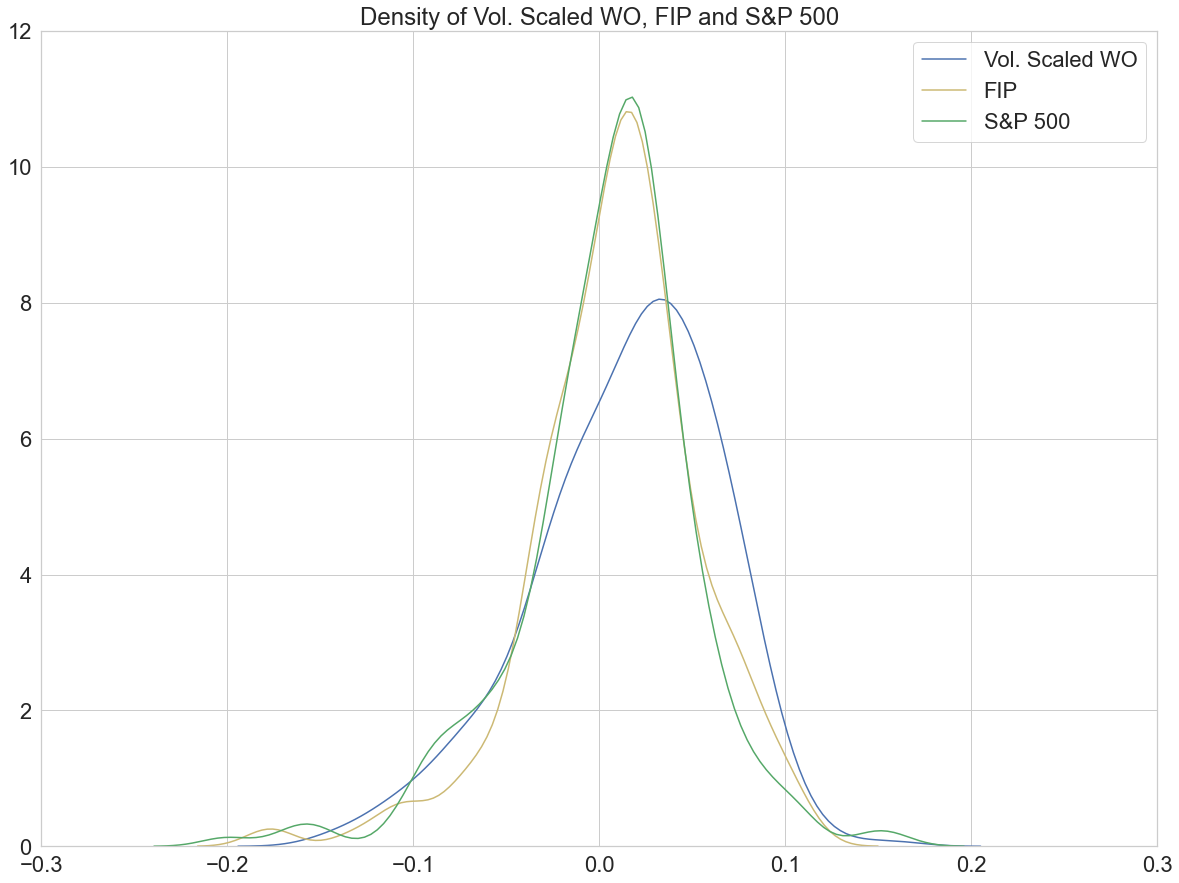

In [13]:
fig = plt.gcf()
sns.set_style("whitegrid")
fig.set_size_inches(20, 15)
p1=sns.kdeplot(MonthlyData['Scaled'], shade=False, color="b", label='Vol. Scaled WO').set_title('Density of Vol. Scaled WO, FIP and S&P 500')
p1=sns.kdeplot(FIPMonthly_test['FIPMonthly'], shade=False, color="y", label='FIP')
p1=sns.kdeplot(SandPreturnsMonthly_test['sandp'], shade=False, color="g", label='S&P 500')
plt.xlim(-0.3, 0.3)
plt.ylim(0, 12)
sns.set(font_scale=2)
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

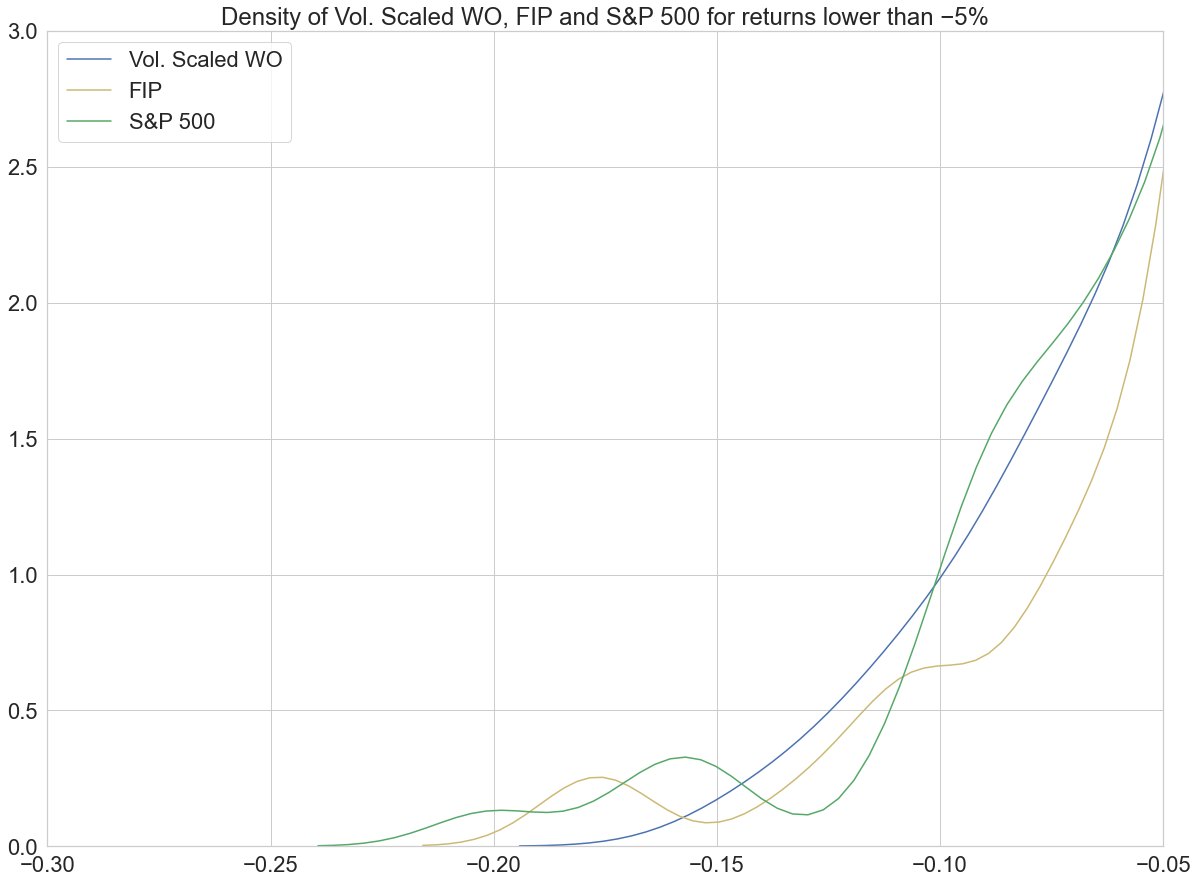

In [14]:
fig = plt.gcf()
sns.set_style("whitegrid")
fig.set_size_inches(20, 15)
p1=sns.kdeplot(MonthlyData['Scaled'], shade=False, color="b", label='Vol. Scaled WO').set_title('Density of Vol. Scaled WO, FIP and S&P 500 for returns lower than −5%')
p1=sns.kdeplot(FIPMonthly_test['FIPMonthly'], shade=False, color="y", label='FIP')
p1=sns.kdeplot(SandPreturnsMonthly_test['sandp'], shade=False, color="g", label='S&P 500')
plt.xlim(-0.3, -0.05)
plt.ylim(0, 3)
sns.set(font_scale=2)
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

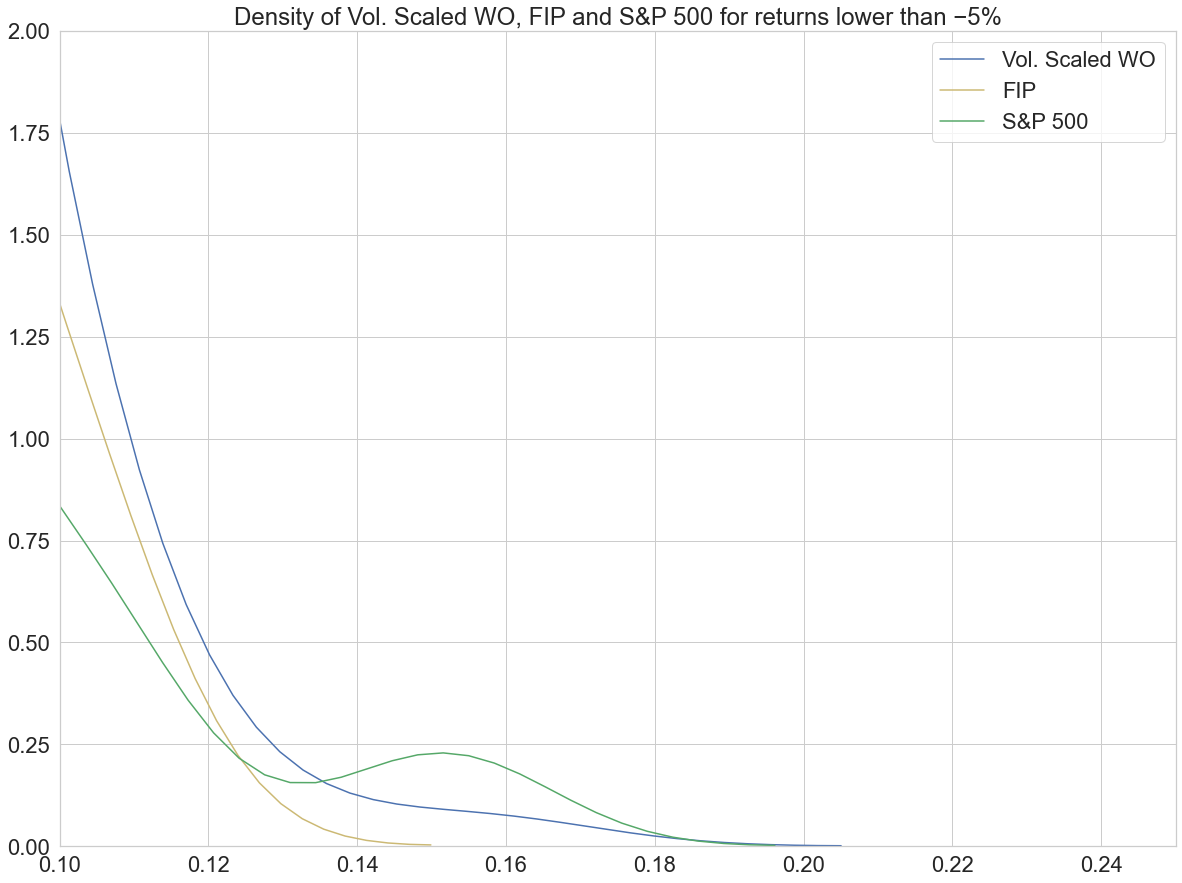

In [15]:
fig = plt.gcf()
fig.set_size_inches(20, 15)
sns.set_style("whitegrid")
p1=sns.kdeplot(MonthlyData['Scaled'], shade=False, color="b", label='Vol. Scaled WO').set_title('Density of Vol. Scaled WO, FIP and S&P 500 for returns lower than −5%')
p1=sns.kdeplot(FIPMonthly_test['FIPMonthly'], shade=False, color="y", label='FIP')
p1=sns.kdeplot(SandPreturnsMonthly_test['sandp'], shade=False, color="g", label='S&P 500')
plt.xlim(0.1, 0.25)
plt.ylim(0, 2)
sns.set(font_scale=2)
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

In [16]:
# SWO look-back period

SWO=WOMonthly.copy()+1
WO_Monthly_Analysis = WOMonthly.copy()

cumret_hi = (SWO['WOMonthly'].rolling(12).apply(np.prod, raw=True)-1)[:-1]
SWO['Pred_hi']=np.nan
SWO['Pred_hi'][1:]=cumret_hi

SWO['WOMonthly']=SWO['WOMonthly']-1

# compute the portfolio return

SWO['Pred_hi'][SWO['Pred_hi']>0]=1
SWO['Pred_hi'][SWO['Pred_hi']<0]=0

WO_Monthly_Analysis['SWO']=SWO['Pred_hi']

#Monthly_Analysis = Monthly_Analysis.loc['2000-05-01':]
WO_Monthly_Analysis = WO_Monthly_Analysis.dropna()
WO_Monthly_Analysis = WO_Monthly_Analysis.loc['2000-05-01':].copy()
WO_Monthly_Analysis.head()

,WOMonthly,SWO
date,,
2000-05-01,-0.010184,1.0
2000-06-01,-0.004882,1.0
2000-07-03,0.008822,1.0
2000-08-01,-0.083157,1.0
2000-09-01,0.070359,1.0


In [17]:
SVR_WO_Forecast = pd.read_pickle('data/SVR_WO_Forecast.pkl')
LSTM_WO_Forecast = pd.read_pickle('data/LSTM_WO_Forecast.pkl')
SdAE_WO_Forecast = pd.read_pickle('data/SdAE_WO_Forecast.pkl')
SmAE_WO_Forecast = pd.read_pickle('data/SmAE_WO_Forecast.pkl')
SdAE_Gauss_WO_Forecast = pd.read_pickle('data/SdAE_Gauss_WO_Forecast.pkl')

In [18]:
def Create_Signal_Returns (data, name):
    
    data['Signal'] = data.copy()
    data[name]=np.nan
    data[name][data['Signal']>0]=1
    data[name][data['Signal']<0]=0
    data = data.iloc[0:244]
    
    return data

In [19]:
WO_SVR = Create_Signal_Returns(SVR_WO_Forecast, 'WO_SVR')
WO_LSTM = Create_Signal_Returns(LSTM_WO_Forecast, 'WO_LSTM')
WO_SdAE = Create_Signal_Returns(SdAE_WO_Forecast, 'WO_SdAE')
WO_SmAE = Create_Signal_Returns(SmAE_WO_Forecast, 'WO_SmAE')
WO_SdAE_Gauss = Create_Signal_Returns(SdAE_Gauss_WO_Forecast, 'WO_SdAE_Gauss')
WO_SVR.tail(5)

,0,Signal,WO_SVR
239,0.010640,0.010640,1.0
240,0.017725,0.017725,1.0
241,0.011503,0.011503,1.0
242,-0.013917,-0.013917,0.0
243,-0.026518,-0.026518,0.0


In [20]:
WO_SVR = WO_SVR.iloc[0:243,:]
WO_LSTM = WO_LSTM.iloc[0:243,:]
WO_SdAE = WO_SdAE.iloc[0:243,:]
WO_SmAE = WO_SmAE.iloc[0:243,:]
WO_SdAE_Gauss = WO_SdAE_Gauss.iloc[0:243,:]
WO_SVR.tail(5)

,0,Signal,WO_SVR
238,0.005753,0.005753,1.0
239,0.010640,0.010640,1.0
240,0.017725,0.017725,1.0
241,0.011503,0.011503,1.0
242,-0.013917,-0.013917,0.0


In [21]:
WOMonthly2 = WOMonthly.loc['2000-05-01':].copy()

SandPreturnsMonthly = SandPreturnsMonthly.loc['2000-05-01':].copy()

In [22]:
WOMonthly2['WO_SVR'] = WO_SVR['WO_SVR'].values
WOMonthly2['SVR_Return'] = WOMonthly2['WOMonthly']*WO_SVR['WO_SVR'].values

WOMonthly2['WO_LSTM'] = WO_LSTM['WO_LSTM'].values
WOMonthly2['LSTM_Return'] = WOMonthly2['WOMonthly']*WO_LSTM['WO_LSTM'].values

WOMonthly2['WO_SdAE'] = WO_SdAE['WO_SdAE'].values
WOMonthly2['SdAE_Return'] = WOMonthly2['WOMonthly']*WO_SdAE['WO_SdAE'].values

WOMonthly2['WO_SmAE'] = WO_SmAE['WO_SmAE'].values
WOMonthly2['SmAE_Return'] = WOMonthly2['WOMonthly']*WO_SmAE['WO_SmAE'].values

WOMonthly2['WO_SdAE_Gauss'] = WO_SdAE_Gauss['WO_SdAE_Gauss'].values
WOMonthly2['SdAE_Gauss_Return'] = WOMonthly2['WOMonthly']*WO_SdAE_Gauss['WO_SdAE_Gauss'].values

WOMonthly2['WO_SWO'] = (WOMonthly2['WOMonthly'])*WO_Monthly_Analysis['SWO'].values

WOMonthly2['Market'] = SandPreturnsMonthly


#WO_MonthlyTransCost = WOMonthly2*0.003
WOMonthly_Final = WOMonthly2.copy()

#subtract(WO_MonthlyTransCost)

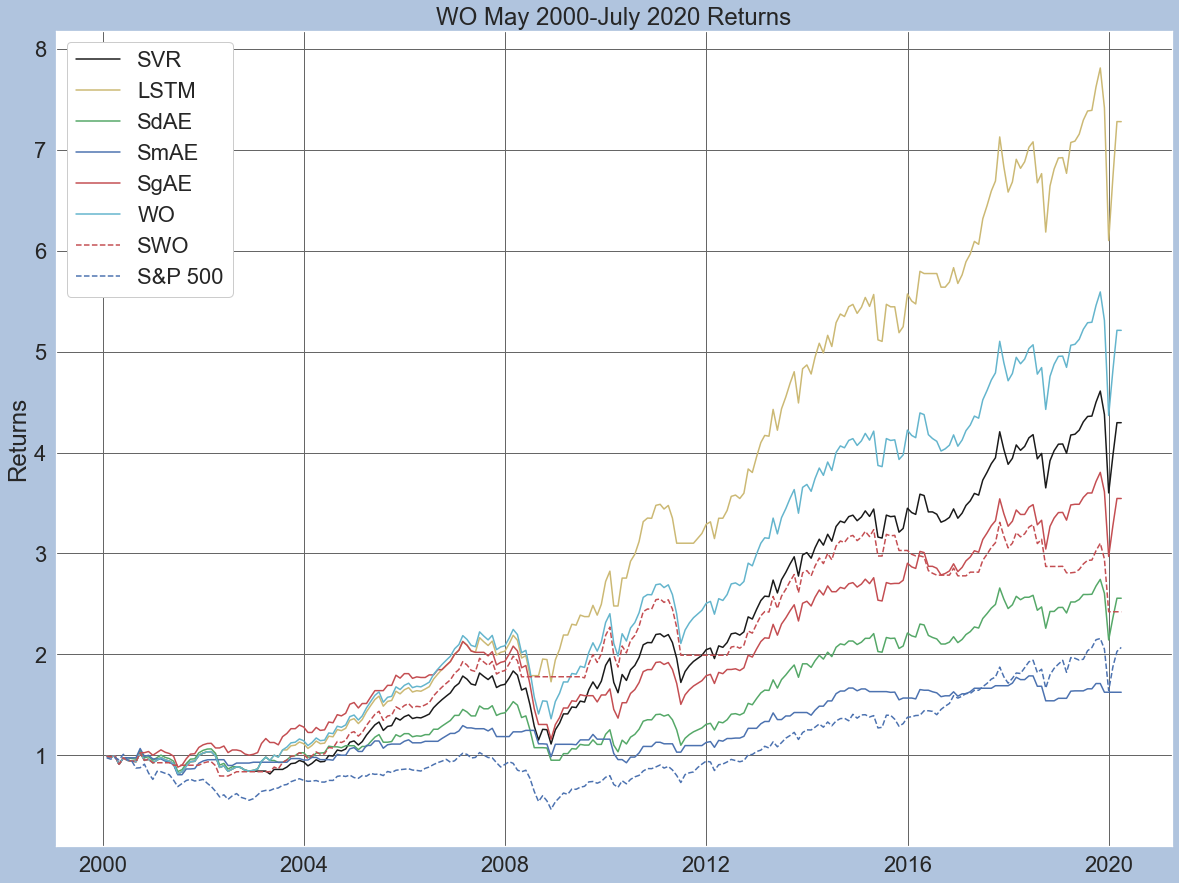

In [23]:
month = 0

WOMonthly_Final['SVRtmp']=WOMonthly_Final['SVR_Return']+1
WOMonthly_Final['SVRcum']=np.cumprod(WOMonthly_Final['SVRtmp'].iloc[month:])

WOMonthly_Final['LSTMtmp']=WOMonthly_Final['LSTM_Return']+1
WOMonthly_Final['LSTMcum']=np.cumprod(WOMonthly_Final['LSTMtmp'].iloc[month:])

WOMonthly_Final['SdAEtmp']=WOMonthly_Final['SdAE_Return']+1
WOMonthly_Final['SdAEcum']=np.cumprod(WOMonthly_Final['SdAEtmp'].iloc[month:])

WOMonthly_Final['SmAEtmp']=WOMonthly_Final['SmAE_Return']+1
WOMonthly_Final['SmAEcum']=np.cumprod(WOMonthly_Final['SmAEtmp'].iloc[month:])

WOMonthly_Final['SdAEGtmp']=WOMonthly_Final['SdAE_Gauss_Return']+1
WOMonthly_Final['SdAE_Gauss_cum']=np.cumprod(WOMonthly_Final['SdAEGtmp'].iloc[month:])

WOMonthly_Final['WOtmp']=WOMonthly_Final['WOMonthly']+1
WOMonthly_Final['WOcum']=np.cumprod(WOMonthly_Final['WOtmp'].iloc[month:])

WOMonthly_Final['SWOtmp']=WOMonthly_Final['WO_SWO']+1
WOMonthly_Final['SWOcum']=np.cumprod(WOMonthly_Final['SWOtmp'].iloc[month:]) 
                              
WOMonthly_Final['MKTtmp']=WOMonthly_Final['Market']+1
WOMonthly_Final['MKTcum']=np.cumprod(WOMonthly_Final['MKTtmp'].iloc[month:]) 


idx = pd.date_range('2000-01-01', periods=243, freq='M') # '2008-01-01', periods=135

plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("white")
plt.rcParams.update({'font.size': 20})
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.plot(idx, (WOMonthly_Final['SVRcum'].iloc[month:]), 'k', label='SVR')
plt.plot(idx, (WOMonthly_Final['LSTMcum'].iloc[month:]), 'y', label='LSTM')
plt.plot(idx, (WOMonthly_Final['SdAEcum'].iloc[month:]), 'g', label='SdAE')
plt.plot(idx, (WOMonthly_Final['SmAEcum'].iloc[month:]), 'b', label='SmAE')
plt.plot(idx, (WOMonthly_Final['SdAE_Gauss_cum'].iloc[month:]), 'r', label='SgAE')
plt.plot(idx, (WOMonthly_Final['WOcum'].iloc[month:]), 'c', label='WO')
plt.plot(idx, (WOMonthly_Final['SWOcum'].iloc[month:]), 'r--', label='SWO')
plt.plot(idx, (WOMonthly_Final['MKTcum'].iloc[month:]), 'b--', label='S&P 500')
plt.title("WO May 2000-July 2020 Returns")                           
plt.ylabel('Returns')
plt.legend(facecolor='white', framealpha=1)
plt.show()
#plt.savefig('regular-cumret-sub.png', bbox_inches='tight')

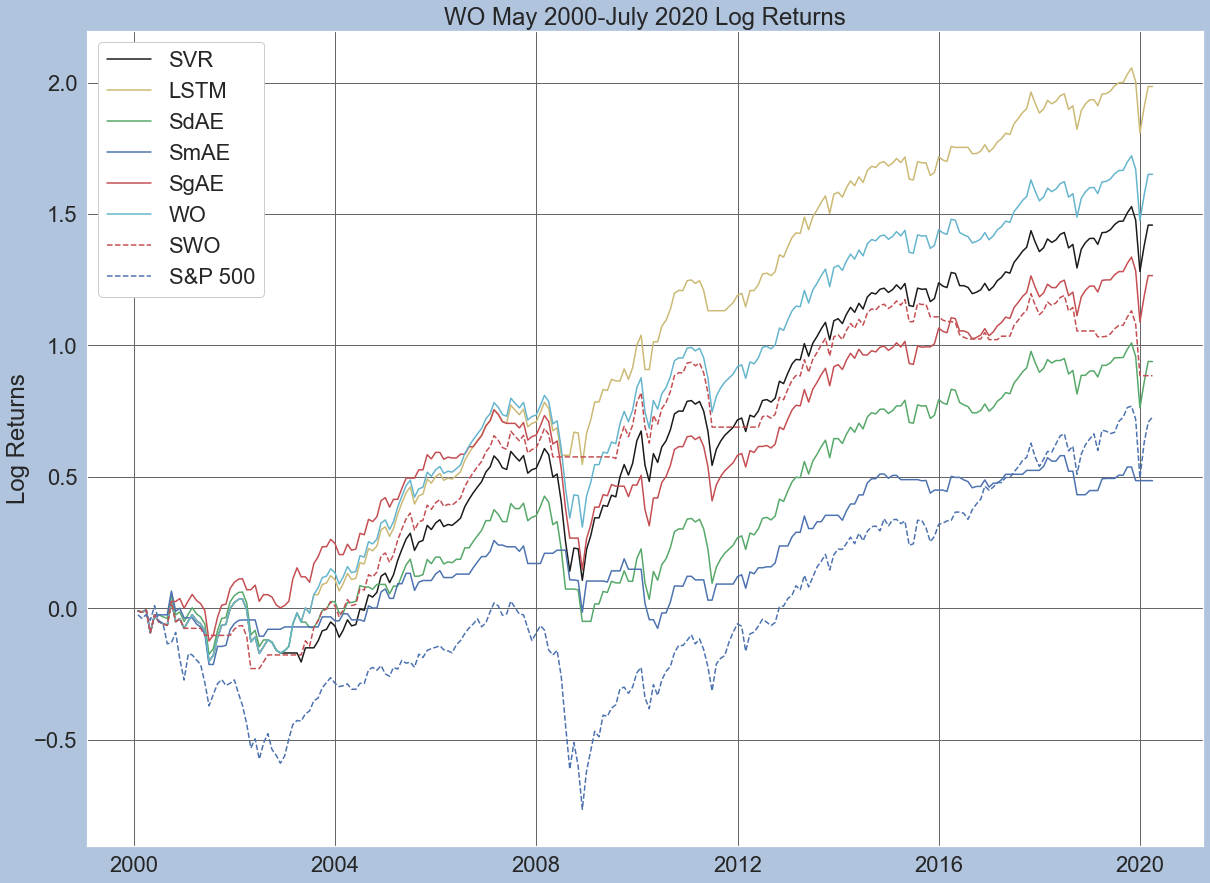

In [24]:
month = 0

WOMonthly_Final['SVRtmp']=WOMonthly_Final['SVR_Return']+1
WOMonthly_Final['SVRcum']=np.cumprod(WOMonthly_Final['SVRtmp'].iloc[month:])

WOMonthly_Final['LSTMtmp']=WOMonthly_Final['LSTM_Return']+1
WOMonthly_Final['LSTMcum']=np.cumprod(WOMonthly_Final['LSTMtmp'].iloc[month:])

WOMonthly_Final['SdAEtmp']=WOMonthly_Final['SdAE_Return']+1
WOMonthly_Final['SdAEcum']=np.cumprod(WOMonthly_Final['SdAEtmp'].iloc[month:])

WOMonthly_Final['SmAEtmp']=WOMonthly_Final['SmAE_Return']+1
WOMonthly_Final['SmAEcum']=np.cumprod(WOMonthly_Final['SmAEtmp'].iloc[month:])

WOMonthly_Final['SdAEGtmp']=WOMonthly_Final['SdAE_Gauss_Return']+1
WOMonthly_Final['SdAE_Gauss_cum']=np.cumprod(WOMonthly_Final['SdAEGtmp'].iloc[month:])

WOMonthly_Final['WOtmp']=WOMonthly_Final['WOMonthly']+1
WOMonthly_Final['WOcum']=np.cumprod(WOMonthly_Final['WOtmp'].iloc[month:])

WOMonthly_Final['SWOtmp']=WOMonthly_Final['WO_SWO']+1
WOMonthly_Final['SWOcum']=np.cumprod(WOMonthly_Final['SWOtmp'].iloc[month:]) 
                              
WOMonthly_Final['MKTtmp']=WOMonthly_Final['Market']+1
WOMonthly_Final['MKTcum']=np.cumprod(WOMonthly_Final['MKTtmp'].iloc[month:]) 

idx = pd.date_range('2000-01-01', periods=243, freq='M') # '2008-01-01', periods=135

plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("white")
plt.rcParams.update({'font.size': 20})
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.plot(idx, np.log(WOMonthly_Final['SVRcum'].iloc[month:]), 'k', label='SVR')
plt.plot(idx, np.log(WOMonthly_Final['LSTMcum'].iloc[month:]), 'y', label='LSTM')
plt.plot(idx, np.log(WOMonthly_Final['SdAEcum'].iloc[month:]), 'g', label='SdAE')
plt.plot(idx, np.log(WOMonthly_Final['SmAEcum'].iloc[month:]), 'b', label='SmAE')
plt.plot(idx, np.log(WOMonthly_Final['SdAE_Gauss_cum'].iloc[month:]), 'r', label='SgAE')
plt.plot(idx, np.log(WOMonthly_Final['WOcum'].iloc[month:]), 'c', label='WO')
plt.plot(idx, np.log(WOMonthly_Final['SWOcum'].iloc[month:]), 'r--', label='SWO')
plt.plot(idx, np.log(WOMonthly_Final['MKTcum'].iloc[month:]), 'b--', label='S&P 500')
plt.title("WO May 2000-July 2020 Log Returns")                           
plt.ylabel('Log Returns')
plt.legend(facecolor='white', framealpha=1)
plt.show()
#plt.savefig('regular-cumret-sub.png', bbox_inches='tight')

# FIP Analysis

In [25]:
# SWO look-back period

SFIP=FIPMonthly.copy()+1
FIP_Monthly_Analysis = FIPMonthly.copy()

cumret_hi2 = (SFIP['FIPMonthly'].rolling(12).apply(np.prod, raw=True)-1)[:-1]
SFIP['Pred_hi']=np.nan
SFIP['Pred_hi'][1:]=cumret_hi2

SFIP['FIPMonthly']=SFIP['FIPMonthly']-1

# compute the portfolio return

SFIP['Pred_hi'][SFIP['Pred_hi']>0]=1
SFIP['Pred_hi'][SFIP['Pred_hi']<0]=0

FIP_Monthly_Analysis['SFIP']=SFIP['Pred_hi']

#Monthly_Analysis = Monthly_Analysis.loc['2000-05-01':]
FIP_Monthly_Analysis = FIP_Monthly_Analysis.dropna()
FIP_Monthly_Analysis = FIP_Monthly_Analysis.loc['2000-05-01':].copy()
FIP_Monthly_Analysis.shape

(243, 2)

In [26]:
SVR_FIP_Forecast = pd.read_pickle('data/SVR_FIP_Forecast.pkl')
LSTM_FIP_Forecast = pd.read_pickle('data/LSTM_FIP_Forecast.pkl')
SdAE_FIP_Forecast = pd.read_pickle('data/SdAE_FIP_Forecast.pkl')
SmAE_FIP_Forecast = pd.read_pickle('data/SmAE_FIP_Forecast.pkl')
SdAE_Gauss_FIP_Forecast = pd.read_pickle('data/SdAE_Gauss_FIP_Forecast.pkl')
LSTM_FIP_Forecast.tail()

,0
239,0.010722
240,0.010479
241,0.009491
242,0.010170
243,0.007131


In [27]:
#LSTM_FIP_Forecast = LSTM_FIP_Forecast.iloc[40:284,:]

In [28]:
def Create_Signal_Returns (data, name):
    
    data['Signal'] = data.copy()
    data[name]=np.nan
    data[name][data['Signal']>0]=1
    data[name][data['Signal']<0]=0
    data = data.iloc[0:244]
    
    return data

In [29]:
FIP_SVR = Create_Signal_Returns(SVR_FIP_Forecast, 'FIP_SVR')
FIP_LSTM = Create_Signal_Returns(LSTM_FIP_Forecast, 'FIP_LSTM')
FIP_SdAE = Create_Signal_Returns(SdAE_FIP_Forecast, 'FIP_SdAE')
FIP_SmAE = Create_Signal_Returns(SmAE_FIP_Forecast, 'FIP_SmAE')
FIP_SdAE_Gauss = Create_Signal_Returns(SdAE_Gauss_FIP_Forecast, 'FIP_SdAE_Gauss')
FIP_LSTM.tail()

,0,Signal,FIP_LSTM
239,0.010722,0.010722,1.0
240,0.010479,0.010479,1.0
241,0.009491,0.009491,1.0
242,0.010170,0.010170,1.0
243,0.007131,0.007131,1.0


In [30]:
FIP_SVR = FIP_SVR.iloc[0:243,:]
FIP_LSTM = FIP_LSTM.iloc[:243,:]
FIP_SdAE = FIP_SdAE.iloc[:243,:]
FIP_SmAE = FIP_SmAE.iloc[:243,:]
FIP_SdAE_Gauss = FIP_SdAE_Gauss.iloc[:243,:]
FIP_LSTM.tail()

,0,Signal,FIP_LSTM
238,0.010627,0.010627,1.0
239,0.010722,0.010722,1.0
240,0.010479,0.010479,1.0
241,0.009491,0.009491,1.0
242,0.010170,0.010170,1.0


In [31]:
FIPMonthly2 = FIPMonthly.loc['2000-05-01':].copy()
SandPreturnsMonthly = SandPreturnsMonthly.loc['2000-05-01':].copy()

In [32]:
FIPMonthly2['FIP_SVR'] = FIP_SVR['FIP_SVR'].values
FIPMonthly2['SVR_Return'] = FIPMonthly2['FIPMonthly']*FIP_SVR['FIP_SVR'].values

FIPMonthly2['FIP_LSTM'] = FIP_LSTM['FIP_LSTM'].values
FIPMonthly2['LSTM_Return'] = FIPMonthly2['FIPMonthly']*FIP_LSTM['FIP_LSTM'].values

FIPMonthly2['FIP_SdAE'] = FIP_SdAE['FIP_SdAE'].values
FIPMonthly2['SdAE_Return'] = FIPMonthly2['FIPMonthly']*FIP_SdAE['FIP_SdAE'].values

FIPMonthly2['FIP_SmAE'] = FIP_SmAE['FIP_SmAE'].values
FIPMonthly2['SmAE_Return'] = FIPMonthly2['FIPMonthly']*FIP_SmAE['FIP_SmAE'].values

FIPMonthly2['FIP_SdAE_Gauss'] = FIP_SdAE_Gauss['FIP_SdAE_Gauss'].values
FIPMonthly2['SdAE_Gauss_Return'] = FIPMonthly2['FIPMonthly']*FIP_SdAE_Gauss['FIP_SdAE_Gauss'].values

FIPMonthly2['FIP_SWO'] = (FIPMonthly2['FIPMonthly'])*FIP_Monthly_Analysis['SFIP'].values

FIPMonthly2['Market'] = SandPreturnsMonthly

#WO_MonthlyTransCost = WOMonthly2*0.003
FIPMonthly_Final = FIPMonthly2.copy()

#subtract(WO_MonthlyTransCost)

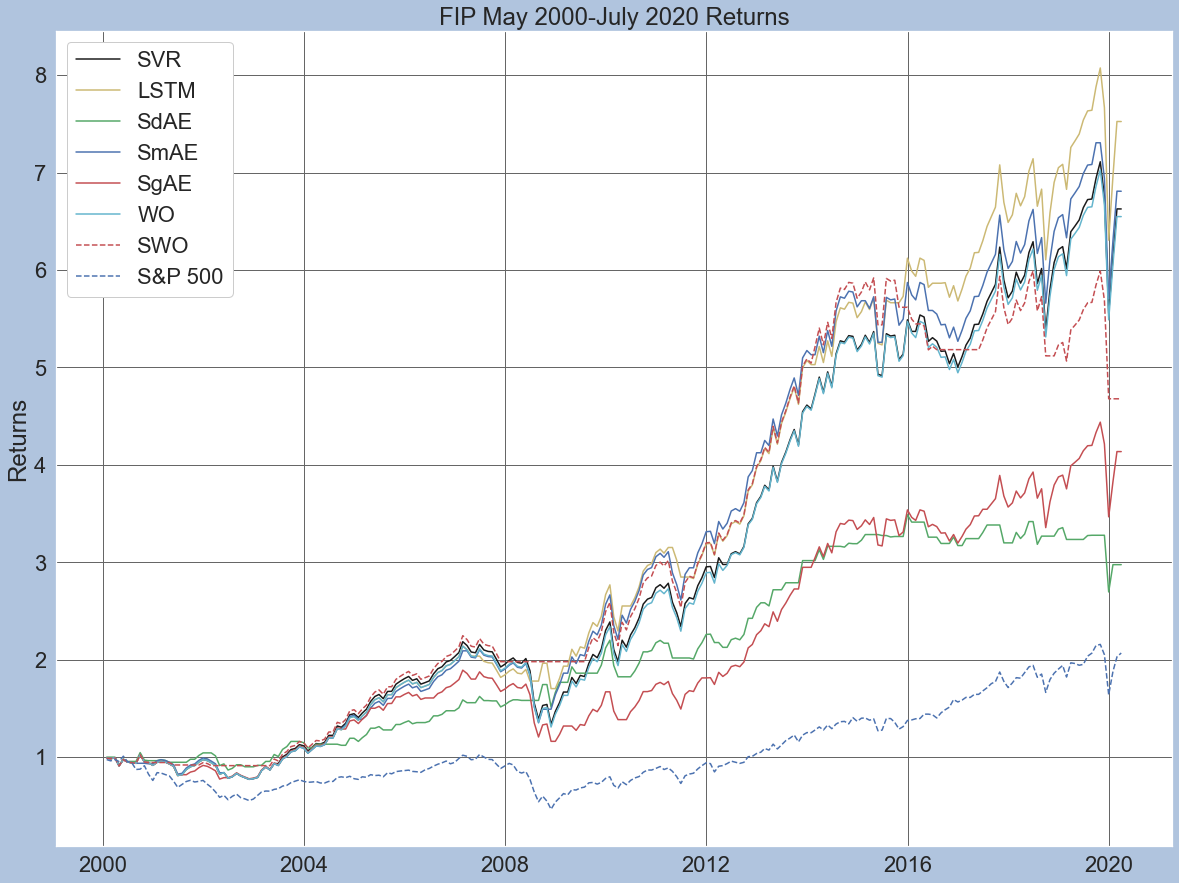

In [33]:
month = 0

FIPMonthly_Final['SVRtmp']=FIPMonthly_Final['SVR_Return']+1
FIPMonthly_Final['SVRcum']=np.cumprod(FIPMonthly_Final['SVRtmp'].iloc[month:])

FIPMonthly_Final['LSTMtmp']=FIPMonthly_Final['LSTM_Return']+1
FIPMonthly_Final['LSTMcum']=np.cumprod(FIPMonthly_Final['LSTMtmp'].iloc[month:])

FIPMonthly_Final['SdAEtmp']=FIPMonthly_Final['SdAE_Return']+1
FIPMonthly_Final['SdAEcum']=np.cumprod(FIPMonthly_Final['SdAEtmp'].iloc[month:])

FIPMonthly_Final['SmAEtmp']=FIPMonthly_Final['SmAE_Return']+1
FIPMonthly_Final['SmAEcum']=np.cumprod(FIPMonthly_Final['SmAEtmp'].iloc[month:])

FIPMonthly_Final['SdAEGtmp']=FIPMonthly_Final['SdAE_Gauss_Return']+1
FIPMonthly_Final['SdAE_Gauss_cum']=np.cumprod(FIPMonthly_Final['SdAEGtmp'].iloc[month:])

FIPMonthly_Final['FIPtmp']=FIPMonthly_Final['FIPMonthly']+1
FIPMonthly_Final['FIPcum']=np.cumprod(FIPMonthly_Final['FIPtmp'].iloc[month:])

FIPMonthly_Final['SFIPtmp']=FIPMonthly_Final['FIP_SWO']+1
FIPMonthly_Final['SFIPcum']=np.cumprod(FIPMonthly_Final['SFIPtmp'].iloc[month:]) 
                              
FIPMonthly_Final['MKTtmp']=FIPMonthly_Final['Market']+1
FIPMonthly_Final['MKTcum']=np.cumprod(FIPMonthly_Final['MKTtmp'].iloc[month:]) 

idx = pd.date_range('2000-01-01', periods=243, freq='M') # '2008-01-01', periods=135

plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("white")
plt.rcParams.update({'font.size': 20})
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.plot(idx, (FIPMonthly_Final['SVRcum'].iloc[month:]), 'k', label='SVR')
plt.plot(idx, (FIPMonthly_Final['LSTMcum'].iloc[month:]), 'y', label='LSTM')
plt.plot(idx, (FIPMonthly_Final['SdAEcum'].iloc[month:]), 'g', label='SdAE')
plt.plot(idx, (FIPMonthly_Final['SmAEcum'].iloc[month:]), 'b', label='SmAE')
plt.plot(idx, (FIPMonthly_Final['SdAE_Gauss_cum'].iloc[month:]), 'r', label='SgAE')
plt.plot(idx, (FIPMonthly_Final['FIPcum'].iloc[month:]), 'c', label='WO')
plt.plot(idx, (FIPMonthly_Final['SFIPcum'].iloc[month:]), 'r--', label='SWO')
plt.plot(idx, (FIPMonthly_Final['MKTcum'].iloc[month:]), 'b--', label='S&P 500')
plt.title("FIP May 2000-July 2020 Returns")                           
plt.ylabel('Returns')
plt.legend(facecolor='white', framealpha=1)
plt.show()
#plt.savefig('regular-cumret-sub.png', bbox_inches='tight')

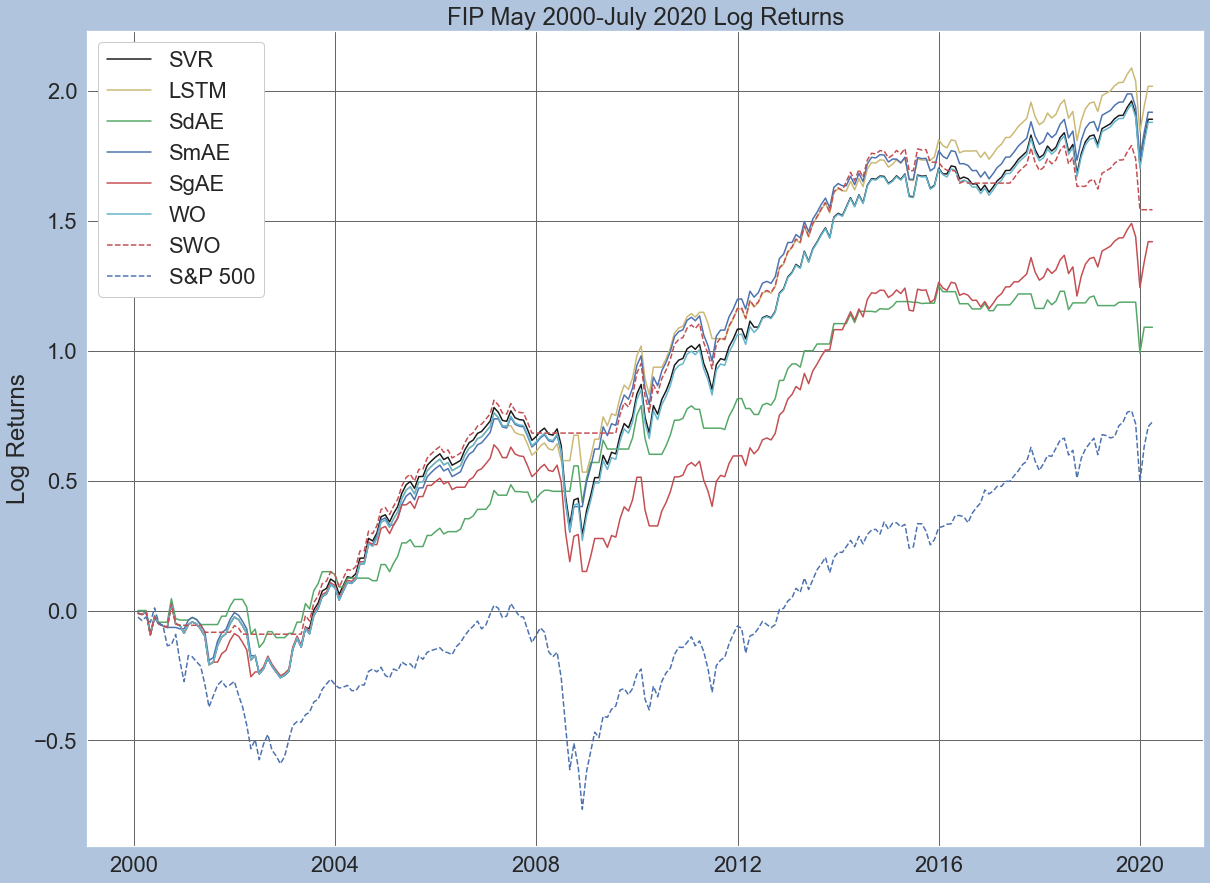

In [34]:
month = 0

FIPMonthly_Final['SVRtmp']=FIPMonthly_Final['SVR_Return']+1
FIPMonthly_Final['SVRcum']=np.cumprod(FIPMonthly_Final['SVRtmp'].iloc[month:])

FIPMonthly_Final['LSTMtmp']=FIPMonthly_Final['LSTM_Return']+1
FIPMonthly_Final['LSTMcum']=np.cumprod(FIPMonthly_Final['LSTMtmp'].iloc[month:])

FIPMonthly_Final['SdAEtmp']=FIPMonthly_Final['SdAE_Return']+1
FIPMonthly_Final['SdAEcum']=np.cumprod(FIPMonthly_Final['SdAEtmp'].iloc[month:])

FIPMonthly_Final['SmAEtmp']=FIPMonthly_Final['SmAE_Return']+1
FIPMonthly_Final['SmAEcum']=np.cumprod(FIPMonthly_Final['SmAEtmp'].iloc[month:])

FIPMonthly_Final['SdAEGtmp']=FIPMonthly_Final['SdAE_Gauss_Return']+1
FIPMonthly_Final['SdAE_Gauss_cum']=np.cumprod(FIPMonthly_Final['SdAEGtmp'].iloc[month:])

FIPMonthly_Final['FIPtmp']=FIPMonthly_Final['FIPMonthly']+1
FIPMonthly_Final['FIPcum']=np.cumprod(FIPMonthly_Final['FIPtmp'].iloc[month:])

FIPMonthly_Final['SFIPtmp']=FIPMonthly_Final['FIP_SWO']+1
FIPMonthly_Final['SFIPcum']=np.cumprod(FIPMonthly_Final['SFIPtmp'].iloc[month:]) 
                              
FIPMonthly_Final['MKTtmp']=FIPMonthly_Final['Market']+1
FIPMonthly_Final['MKTcum']=np.cumprod(FIPMonthly_Final['MKTtmp'].iloc[month:]) 

idx = pd.date_range('2000-01-01', periods=243, freq='M') # '2008-01-01', periods=135

plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("white")
plt.rcParams.update({'font.size': 20})
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.plot(idx, np.log(FIPMonthly_Final['SVRcum'].iloc[month:]), 'k', label='SVR')
plt.plot(idx, np.log(FIPMonthly_Final['LSTMcum'].iloc[month:]), 'y', label='LSTM')
plt.plot(idx, np.log(FIPMonthly_Final['SdAEcum'].iloc[month:]), 'g', label='SdAE')
plt.plot(idx, np.log(FIPMonthly_Final['SmAEcum'].iloc[month:]), 'b', label='SmAE')
plt.plot(idx, np.log(FIPMonthly_Final['SdAE_Gauss_cum'].iloc[month:]), 'r', label='SgAE')
plt.plot(idx, np.log(FIPMonthly_Final['FIPcum'].iloc[month:]), 'c', label='WO')
plt.plot(idx, np.log(FIPMonthly_Final['SFIPcum'].iloc[month:]), 'r--', label='SWO')
plt.plot(idx, np.log(FIPMonthly_Final['MKTcum'].iloc[month:]), 'b--', label='S&P 500')
plt.title("FIP May 2000-July 2020 Log Returns")                           
plt.ylabel('Log Returns')
plt.legend(facecolor='white', framealpha=1)
plt.show()
#plt.savefig('regular-cumret-sub.png', bbox_inches='tight')

# Performance Measures

In [35]:
def max_drawdown(X):
    mdd = 0
    peak = X.iloc[0]
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd

def performance_measures(inp, mkt): 
    excess=inp-mkt
    D = len(inp)
    anret=inp.add(1).prod() ** (12 / D) - 1
    anvol=inp.std()*(math.sqrt(12))
    

    print('Mean: ', inp.mean())
    print('Max: ', inp.max())
    print('Min: ', inp.min())
    print('Ann. Return: ', anret)
    print('Ann. Volatility: ', anvol)
    print('Sharpe Ratio: ', anret/anvol) 
    print('Kurtosis: ', kurtosis(inp))
    print('Skewness: ', skew(inp))
    print('MDD: ', max_drawdown((inp+1).cumprod()))

In [36]:
performance_measures(WOMonthly_Final['WO_SWO'],WOMonthly_Final['Market'].values)

Mean:  0.0043291031884695776
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.04465628641836794
Ann. Volatility:  0.126862343720663
Sharpe Ratio:  0.35200584435595955
Kurtosis:  3.537568493093148
Skewness:  -0.8646317613523511
MDD:  0.268010248926623


In [37]:
performance_measures(WOMonthly_Final['SVR_Return'],WOMonthly_Final['Market'].values)

Mean:  0.007030261396469207
Max:  0.1257219286987381
Min:  -0.177527583921558
Ann. Return:  0.07464076248241569
Ann. Volatility:  0.1546319341779517
Sharpe Ratio:  0.4826995334386653
Kurtosis:  1.8309052004774786
Skewness:  -0.8104129955392713
MDD:  0.39428512937304216


In [38]:
performance_measures(WOMonthly_Final['LSTM_Return'],WOMonthly_Final['Market'].values)

Mean:  0.009088575098699384
Max:  0.1257219286987381
Min:  -0.177527583921558
Ann. Return:  0.10299476313271572
Ann. Volatility:  0.1450823594343234
Sharpe Ratio:  0.7099054877125837
Kurtosis:  2.1109341008912876
Skewness:  -0.7008236475425207
MDD:  0.21893532799874402


In [39]:
performance_measures(WOMonthly_Final['SdAE_Return'],WOMonthly_Final['Market'].values)

Mean:  0.004777299403604429
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.047443456592324296
Ann. Volatility:  0.14610507559085087
Sharpe Ratio:  0.324721481443833
Kurtosis:  2.275472170879949
Skewness:  -0.8739983830934857
MDD:  0.378987069239007


In [40]:
performance_measures(WOMonthly_Final['SmAE_Return'],WOMonthly_Final['Market'].values)

Mean:  0.0024787481255777125
Max:  0.1257219286987381
Min:  -0.12216406810157339
Ann. Return:  0.024257179096922377
Ann. Volatility:  0.10684726403008887
Sharpe Ratio:  0.22702667510598493
Kurtosis:  4.082076034860749
Skewness:  -0.5556460589531887
MDD:  0.28445153020705494


In [41]:
performance_measures(WOMonthly_Final['SdAE_Gauss_Return'],WOMonthly_Final['Market'].values)

Mean:  0.006123398289865748
Max:  0.1257219286987381
Min:  -0.177527583921558
Ann. Return:  0.06448946644165132
Ann. Volatility:  0.14587277661366138
Sharpe Ratio:  0.4420939118232408
Kurtosis:  2.5023677308586185
Skewness:  -0.8226107658962766
MDD:  0.45576900322879305


In [42]:
performance_measures(WOMonthly_Final['SdAE_Gauss_Return'],WOMonthly_Final['Market'].values)

Mean:  0.006123398289865748
Max:  0.1257219286987381
Min:  -0.177527583921558
Ann. Return:  0.06448946644165132
Ann. Volatility:  0.14587277661366138
Sharpe Ratio:  0.4420939118232408
Kurtosis:  2.5023677308586185
Skewness:  -0.8226107658962766
MDD:  0.45576900322879305


In [43]:
performance_measures(WOMonthly_Final['WOMonthly'],WOMonthly_Final['Market'].values)

Mean:  0.007856058890792696
Max:  0.1257219286987381
Min:  -0.177527583921558
Ann. Return:  0.08493796402957843
Ann. Volatility:  0.15667851526255736
Sharpe Ratio:  0.5421162173208103
Kurtosis:  1.7030283685173648
Skewness:  -0.7962454140371541
MDD:  0.39428512937304216


## FIP Performance Measures

In [44]:
performance_measures(FIPMonthly_Final['FIP_SWO'],FIPMonthly_Final['Market'].values)

Mean:  0.007017900162905541
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.07917056754173069
Ann. Volatility:  0.12433835785540988
Sharpe Ratio:  0.6367348653083891
Kurtosis:  3.495691346958564
Skewness:  -0.570410994495138
MDD:  0.21900906503735953


In [45]:
performance_measures(FIPMonthly_Final['SVR_Return'],FIPMonthly_Final['Market'].values)

Mean:  0.008855907330957384
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.09789009874167309
Ann. Volatility:  0.15702647308547685
Sharpe Ratio:  0.6233986971635473
Kurtosis:  2.096208740291731
Skewness:  -0.7803980084870588
MDD:  0.38824481048671844


In [46]:
performance_measures(FIPMonthly_Final['LSTM_Return'],FIPMonthly_Final['Market'].values)

Mean:  0.009211535431295605
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.10479585474930686
Ann. Volatility:  0.14406194322973115
Sharpe Ratio:  0.7274360764535304
Kurtosis:  2.073824338421252
Skewness:  -0.6401183221120809
MDD:  0.24650617638355857


In [47]:
performance_measures(FIPMonthly_Final['SdAE_Return'],FIPMonthly_Final['Market'].values)

Mean:  0.005082723634389691
Max:  0.10399936250850435
Min:  -0.177527583921558
Ann. Return:  0.05532861392713362
Ann. Volatility:  0.11780218044807927
Sharpe Ratio:  0.469673937415101
Kurtosis:  5.498989605364914
Skewness:  -0.7110034454815899
MDD:  0.22719933387789695


In [48]:
performance_measures(FIPMonthly_Final['SmAE_Return'],FIPMonthly_Final['Market'].values)

Mean:  0.008889399885173765
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.0993582895661762
Ann. Volatility:  0.15114477993885478
Sharpe Ratio:  0.6573716247849998
Kurtosis:  2.3616673838594
Skewness:  -0.7386579324512923
MDD:  0.3565171395245951


In [49]:
performance_measures(FIPMonthly_Final['SdAE_Gauss_Return'],FIPMonthly_Final['Market'].values)

Mean:  0.006818986639533888
Max:  0.10399936250850435
Min:  -0.177527583921558
Ann. Return:  0.072629759797876
Ann. Volatility:  0.15033596550073697
Sharpe Ratio:  0.4831163291895043
Kurtosis:  2.56898023168074
Skewness:  -0.8528770370908998
MDD:  0.38590924207652694


In [50]:
performance_measures(FIPMonthly_Final['FIP_SWO'],FIPMonthly_Final['Market'].values)

Mean:  0.007017900162905541
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.07917056754173069
Ann. Volatility:  0.12433835785540988
Sharpe Ratio:  0.6367348653083891
Kurtosis:  3.495691346958564
Skewness:  -0.570410994495138
MDD:  0.21900906503735953


In [51]:
performance_measures(FIPMonthly_Final['FIPMonthly'],FIPMonthly_Final['Market'].values)

Mean:  0.008808441543736147
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.097242956880492
Ann. Volatility:  0.15718621696888777
Sharpe Ratio:  0.6186481153098782
Kurtosis:  2.073063998017343
Skewness:  -0.7761089452700124
MDD:  0.38824481048671844


In [52]:
MonthlyDataScaled = MonthlyData.loc['2000-05-01':,:].copy()

In [53]:
performance_measures(MonthlyDataScaled['Scaled'],FIPMonthly_Final['Market'].values)

Mean:  0.01109963857280523
Max:  0.15654279425902015
Min:  -0.14571348022390349
Ann. Return:  0.12343281692443964
Ann. Volatility:  0.17952844337528756
Sharpe Ratio:  0.6875390584566857
Kurtosis:  0.23666371943358477
Skewness:  -0.5678106265875396
MDD:  0.35667174715257505


In [54]:
D = len(FIPMonthly_Final['Market'])
MktAnnReturn=FIPMonthly_Final['Market'].add(1).prod() ** (12 / D) - 1
MktAnnVol=FIPMonthly_Final['Market'].std()*(math.sqrt(12))
MktSharpe=MktAnnReturn/MktAnnVol

print(MktAnnReturn,MktAnnVol,MktSharpe)

0.036556945985925626 0.166828727800499 0.21912860253686042


In [55]:
stop

NameError: name 'stop' is not defined

In [ ]:
FIPMonthly_Final.to_excel('FIPMonthly_Final.xlsx')

In [ ]:
WOMonthly_Final.to_excel('WOMonthly_Final.xlsx')